In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets,transforms,models
import torchvision
import torch.nn.functional as F

In [2]:
import cv2 as cv
# import pytesseract as tess
import glob
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np

### 传统形式

In [6]:
'''
读取文件夹下所有图片，将其二值化
高斯核去掉噪音，然后使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img(images):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        blur = cv.GaussianBlur(img,(5,5),0)
        ret,thImg = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)  #修改THRESH_BINARY
        Gimg_list.append(thImg) 
    return Gimg_list

In [7]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小并且进行norm
输入：input_dir：读取的文件夹，可使用模糊匹配
输出：图像列表，图片的路径列表
'''
def readImgAPathWithNorm(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    paths = [path for path in glob.glob(glob_dir)]
    if Rmap==0:
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    images = binary_img(images)
    labels = [name.split(os.path.sep)[-2] for name in paths] #读取对应的路径
    images = np.array(images)/255 #将一张图归一化
    return images,labels

In [8]:
'''
读取文件夹下所有图片，将其二值化(不去噪)
使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img_noBlur(images):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        ret,thImg = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)  #修改THRESH_BINARY
        Gimg_list.append(thImg) 
    return Gimg_list

In [9]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小并且进行norm
输入：input_dir：读取的文件夹，可使用模糊匹配
输出：图像列表，图片标签
'''
def readImgAPathWithNorm_noBlur(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    paths = [path for path in glob.glob(glob_dir)]
    if Rmap==0:
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    images = binary_img_noBlur(images)
    labels = [name.split(os.path.sep)[-2] for name in paths] #读取对应的路径
    images = np.array(images)/255 #将一张图归一化
    return images,labels

In [10]:
'''
显示图片
输入：图片矩阵，画布大小：元组（宽，高）
'''
def showImg(img,figsize=(4,4),cmap = "gray"):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img,cmap = cmap)
    plt.show()

In [11]:
test_input_dir = "../result/temp_data/?/"
test_images,test_labels = readImgAPathWithNorm(test_input_dir)
# images_divert = [cv.bitwise_not(item) for item in test_images]  #反转图像黑白转换

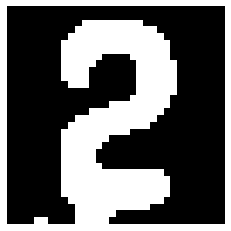

In [12]:
showImg(test_images[500])

In [13]:
test_input_dir = "../result/temp_data/?/"
test_images,test_labels = readImgAPathWithNorm(test_input_dir)

In [14]:
train_input_dir = "../result/augment_data/augment_mask_Gaussion/?/"
train_images,train_labels = readImgAPathWithNorm_noBlur(train_input_dir)

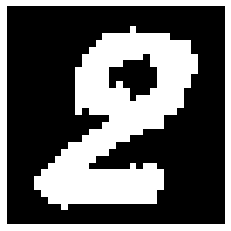

In [22]:
showImg(train_images[110])

In [16]:
train_x, val_x, train_y, val_y = train_test_split(train_images, train_labels, test_size = 0.1)

In [17]:
train_x.shape,val_x.shape

((1620, 32, 32), (180, 32, 32))

### 使用pytorch的形式读取

### 三通道

In [128]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), # 归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize((0.5,0.5,0.5),
                                                            (0.5,0.5,0.5)) #变换到【-1 ，1】
                                      ])


test_valid_transforms = transforms.Compose([
                                       transforms.Resize(32),
                                       transforms.ToTensor(), #归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize((0.5,0.5,0.5),
                                                            (0.5,0.5,0.5))
])

### 灰度图形式读取

In [23]:
train_transforms = transforms.Compose([
                                       transforms.Grayscale(),
                                       transforms.RandomRotation(5),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), # 归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize([0.5],[0.5]) #变换到【-1 ，1】
                                      ])


test_valid_transforms = transforms.Compose([
                                       transforms.Grayscale(),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), #归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize([0.5],[0.5])
])

#### 分为test、train

#### 参数

In [54]:

batch_size = 64
lr = 0.001

In [55]:
train_dir = "../result/augment_data/train/"
test_dir = "../result/augment_data/test/"
test_data = datasets.ImageFolder(test_dir,transform = test_valid_transforms)
train_data = datasets.ImageFolder(train_dir,transform = train_transforms)
# valid_data = datasets.ImageFolder(valid_dir,transform = test_valid_transforms)
# 使用预处理格式加载图像

In [64]:
# 创建三个加载器，分别为训练，验证，测试，将训练集的batch大小设为64，即每次加载器向网络输送64张图片，随机打乱
trainloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_data,batch_size = batch_size)

In [65]:
range(len(trainloader))

range(0, 560)

#### 预览

In [28]:
def imshow(img):
    """
    展示图片
    img:图片数据
    """
#     img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()  # 将数据转换成numpy格式
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    
# 随机获取部分训练数据
dataiter = iter(trainloader) #迭代器
images, labels = dataiter.next() #每一条数据大小为16
classes = train_data.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    3     6     T     Q     0     P     Y     G


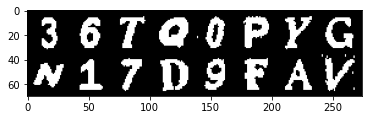

In [29]:
# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(" ".join('%5s' % classes[labels[j]] for j in range(8))) 

#### 模型训练1

In [58]:
import torch.nn as nn
import torch.nn.functional as F

# 如果有gpu的可使用GPU加速
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1)
        # 定义第一个池化层
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 定义第二个卷积层
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        # 定义第二个池化层
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 定义第一个全连接层
        self.fc1 = nn.Linear(1296, 128)
        # 定义第二个全连接层
        self.fc2 = nn.Linear(128, 36)
    
    def forward(self, x):
        # 连接各个cnn各个模块
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x=x.view(-1, 36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        # 返回运算后的结果
        return x

# 实例化模型
net = CNNNet()
net.to(device)  # 模型设备转移
# 查看模型
print(net)


CNNNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)


In [59]:
## 选择优化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [60]:
mini_batch = 150
n_epochs = 50
## 训练模型
for epoch in range(n_epochs):
    running_loss = 0.0
    # 迭代，批次训练
    for i, data in enumerate(trainloader):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 权重参数梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        outputs = net(inputs)
        # 计算损失值
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 损失值累加
        running_loss += loss.item()
        # 每2000个mini-batch显示一次损失值
        if i % mini_batch == (mini_batch-1):
            print('[%d, %d] loss:%.3f' % (epoch + 1, i + 1, running_loss / mini_batch))
            running_loss = 0.0
print('Finished Training')


[1, 150] loss:3.562
[1, 300] loss:3.473
[1, 450] loss:3.068
[2, 150] loss:1.933
[2, 300] loss:1.740
[2, 450] loss:1.729
[3, 150] loss:1.567
[3, 300] loss:1.420
[3, 450] loss:1.360
[4, 150] loss:1.324
[4, 300] loss:1.311
[4, 450] loss:1.292
[5, 150] loss:1.230
[5, 300] loss:1.183
[5, 450] loss:1.129
[6, 150] loss:1.019
[6, 300] loss:0.889
[6, 450] loss:0.786
[7, 150] loss:0.753
[7, 300] loss:0.762
[7, 450] loss:0.760
[8, 150] loss:0.706
[8, 300] loss:0.742
[8, 450] loss:0.643
[9, 150] loss:0.602
[9, 300] loss:0.614
[9, 450] loss:0.591
[10, 150] loss:0.596
[10, 300] loss:0.594
[10, 450] loss:0.530
[11, 150] loss:0.481
[11, 300] loss:0.475
[11, 450] loss:0.470
[12, 150] loss:0.462
[12, 300] loss:0.440
[12, 450] loss:0.342
[13, 150] loss:0.356
[13, 300] loss:0.345
[13, 450] loss:0.328
[14, 150] loss:0.337
[14, 300] loss:0.329
[14, 450] loss:0.340
[15, 150] loss:0.322
[15, 300] loss:0.315
[15, 450] loss:0.320
[16, 150] loss:0.315
[16, 300] loss:0.301
[16, 450] loss:0.302
[17, 150] loss:0.30

In [61]:
#验证准确率
def accuracy_test(model,dataloader):
    correct = 0
    total = 0
    model.cuda() # 将模型放入GPU计算，能极大加快运算速度
    with torch.no_grad(): # 使用验证集时关闭梯度计算
        for data in dataloader:
           
            images,labels = data
            images,labels = images.to('cuda'),labels.to('cuda')

            outputs = model(images)
            _, predicted = torch.max(outputs.data,1) 
            # torch.max返回输出结果中，按dim=1行排列的每一行最大数据及他的索引，丢弃数据，保留索引
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            #将预测及标签两相同大小张量逐一比较各相同元素的个数
    print('the accuracy is {:.4f}'.format(correct/total))


In [62]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        images,labels = images.to('cuda'),labels.to('cuda')
        outputs = net(images)
        _,predicted = torch.max(outputs.data,dim=1)
        total += labels.size(0)
        correct+=(predicted==labels).sum().item()
    print("acc on test: %d %%" % (100*correct/total))

acc on test: 34 %


In [63]:
accuracy_test(net,testloader)

the accuracy is 0.3424


### 模型训练2

In [66]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数设置
num_epochs = 50
num_classes = 36
image_size = 32  #图像的总尺寸32*32
learning_rate = 0.01


In [67]:
train_transforms = transforms.Compose([
                                       transforms.Grayscale(),
                                       transforms.RandomRotation(5),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), # 归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize([0.5],[0.5]) #变换到【-1 ，1】
                                      ])


test_valid_transforms = transforms.Compose([
                                       transforms.Grayscale(),
                                       transforms.Resize(32),
                                       transforms.ToTensor(), #归一化  对图像进行张量化，以便神经网络处理
                                       transforms.Normalize([0.5],[0.5])
])

In [71]:
train_dir = "../result/augment_data/train/"
test_dir = "../result/augment_data/test/"
test_data = datasets.ImageFolder(test_dir,transform = test_valid_transforms)
train_data = datasets.ImageFolder(train_dir,transform = train_transforms)

In [72]:
testAll_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size)

In [73]:
#下标
batch_size = 8  # 一个batch 的大小
indices = range(len(test_data))
indices_val = indices[:1482]
indices_test = indices[1482:]  
# 通过下标对验证集和测试集进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
# 根据采样器来定义加载器，然后加载数据
validation_loader = torch.utils.data.DataLoader(dataset =test_data,batch_size = batch_size,sampler = sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,sampler = sampler_test)
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=4)

In [74]:
print(len(train_loader))
print(len(train_loader.dataset))

4474
35792


In [75]:
#定义两个卷积层的厚度（feature map的数量）
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,depth[0],5,padding=2) # 1 input channel, 4 output channels, 5x5 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2) #定义一个Pooling层
        self.conv2 = nn.Conv2d(depth[0],depth[1],5, padding = 2) #第二层卷积:4input channel, 8 output channels, 5x5 square convolution kernel
        self.fc1 = nn.Linear( depth[1] * image_size // 4 * image_size // 4 , 512) #线性连接层的输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为512，输出为要做分类的类别数  
        
    def forward(self, x):
        # x尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))  #第一层卷积的激活函数用ReLu
        x = self.pool(x) #第二层pooling，将片变小
        
        #x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)
        x = F.relu(self.conv2(x)) #第三层卷积，输入输出通道分别为depth[0]=4, depth[1]=8
        x = self.pool(x) #第四层pooling，将图片缩小到原大小的1/4
        
        #x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)
        # view函数将张量x变形成一维的向量形式，总特征数batch_size * (image_size//4)^2*depth[1]不改变，为接下来的全连接作准备。
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)
        x = F.relu(self.fc1(x)) #第五层为全链接，ReLu激活函数
        
        #x的尺寸：(batch_size, 512)
        # dropout 参数training：pply dropout if is True. Defualt: True
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作，为了防止过拟合
        x = self.fc2(x) 
        
        #x的尺寸：(batch_size, num_classes)
        #输出层为log_softmax，即概率对数值log(p(x))。采用log_softmax可以使得后面的交叉熵计算更快
        #log_softmax虽然等价于log(softmax(x))，但是分开两个运算会速度比较慢，数值也不稳定。
        # dim=0 ，即softmax后横向的和为1
        x = F.log_softmax(x, dim = 0) 
        return x
    
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        #print('type(feature_map1)=',feature_map1)
        #type是一个四维的tensor
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)


In [76]:
"""计算预测正确率的函数，其中predictions是模型给出的一组预测结果：batch_size行num_classes列的矩阵，labels是真正的label"""
def accuracy(predictions, labels):
    # torch.max的输出：out (tuple, optional维度) – the result tuple of two output tensors (max, max_indices)
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    right_num = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return right_num, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [83]:
net = ConvNet()
# net.to(device)
criterion = nn.CrossEntropyLoss() #Loss函数的定义，交叉熵
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #定义优化器，普通的随机梯度下降算法

record = [] #记录训练集和验证集上错误率的list
weights = [] #每若干步就记录一次卷积核

for epoch in range(num_epochs):
    train_accuracy = [] #记录训练数据集准确率的容器
    # 一次迭代一个batch的 data 和 target
    for batch_id, (data,target) in enumerate(train_loader):
#         data = data.to(device)
#         target = target.to(device)
        net.train() # 给网络模型做标记，打开关闭net的training标志,从而决定是否运行dropout
        output =  net(data) #forward  
        loss = criterion(output, target) 
#         print(batch_id,":loss ",loss)
        optimizer.zero_grad()
        loss.backward()   #反向传播
        optimizer.step()  #更新权重
        
        accuracies = accuracy(output, target)
#         print("output:",output)
#         print("target",target)
        train_accuracy.append(accuracies)
#         print(batch_id,"acc:",accuracies)
        if batch_id% 500 ==499: #每间隔100个batch执行一次打印等操作
            net.eval() # 给网络模型做标记，将模型转换为测试模式。
            val_accuracy = [] #记录校验数据集准确率的容器
            
            for (data, target) in validation_loader: #计算校验集上面的准确度
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                accuracies = accuracy(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_accuracy.append(accuracies)
                
            # 分别计算在已经计算过的训练集，以及全部校验集上模型的分类准确率
            
            #train_r为一个二元组，分别记录目前  已经经历过的所有  训练集中分类正确的数量和该集合中总的样本数，
            train_r = (sum([tup[0] for tup in train_accuracy]), sum([tup[1] for tup in train_accuracy]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_accuracy]), sum([tup[1] for tup in val_accuracy]))
            
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前batch的正确率的平均值
            print('Epoch [{}/{}] [{}/{}]  Loss: {:.3f}  训练集准确率: {:.2f}%  验证集准确率: {:.2f}%'.format(
                epoch+1,num_epochs, batch_id * batch_size, len(train_loader.dataset),
                loss.item(), 
                100 * train_r[0] / train_r[1], 
                100 * val_r[0] / val_r[1]))
            
            #将准确率和权重等数值加载到容器中，方便后续处理
            
            record.append((100 - 100 * train_r[0] / train_r[1],100 - 100 * val_r[0] / val_r[1]))
            
            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])


Epoch [1/50] [3992/35792]  Loss: 2.666  训练集准确率: 19.50%  验证集准确率: 12.28%
Epoch [1/50] [7992/35792]  Loss: 1.854  训练集准确率: 34.01%  验证集准确率: 13.50%
Epoch [1/50] [11992/35792]  Loss: 2.086  训练集准确率: 41.28%  验证集准确率: 18.89%
Epoch [1/50] [15992/35792]  Loss: 1.241  训练集准确率: 46.10%  验证集准确率: 28.61%
Epoch [1/50] [19992/35792]  Loss: 1.710  训练集准确率: 50.35%  验证集准确率: 25.17%
Epoch [1/50] [23992/35792]  Loss: 0.914  训练集准确率: 53.45%  验证集准确率: 15.99%
Epoch [1/50] [27992/35792]  Loss: 0.851  训练集准确率: 56.05%  验证集准确率: 21.79%
Epoch [1/50] [31992/35792]  Loss: 0.940  训练集准确率: 58.16%  验证集准确率: 26.25%
Epoch [2/50] [3992/35792]  Loss: 0.937  训练集准确率: 76.05%  验证集准确率: 29.15%
Epoch [2/50] [7992/35792]  Loss: 2.056  训练集准确率: 76.03%  验证集准确率: 26.86%
Epoch [2/50] [11992/35792]  Loss: 0.905  训练集准确率: 76.53%  验证集准确率: 30.03%
Epoch [2/50] [15992/35792]  Loss: 0.920  训练集准确率: 76.97%  验证集准确率: 31.44%
Epoch [2/50] [19992/35792]  Loss: 1.128  训练集准确率: 77.31%  验证集准确率: 34.75%
Epoch [2/50] [23992/35792]  Loss: 1.146  训练集准确率: 77.68%  验证集准确率: 31.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020A9D028DC0>
Traceback (most recent call last):
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch [3/50] [11992/35792]  Loss: 1.055  训练集准确率: 80.59%  验证集准确率: 31.11%
Epoch [3/50] [15992/35792]  Loss: 1.100  训练集准确率: 80.75%  验证集准确率: 33.00%
Epoch [3/50] [19992/35792]  Loss: 0.850  训练集准确率: 80.86%  验证集准确率: 34.14%
Epoch [3/50] [23992/35792]  Loss: 0.652  训练集准确率: 81.04%  验证集准确率: 30.23%
Epoch [3/50] [27992/35792]  Loss: 1.068  训练集准确率: 81.17%  验证集准确率: 28.41%
Epoch [3/50] [31992/35792]  Loss: 1.233  训练集准确率: 81.30%  验证集准确率: 33.20%
Epoch [4/50] [3992/35792]  Loss: 0.950  训练集准确率: 83.22%  验证集准确率: 35.96%
Epoch [4/50] [7992/35792]  Loss: 0.504  训练集准确率: 82.95%  验证集准确率: 37.04%
Epoch [4/50] [11992/35792]  Loss: 0.602  训练集准确率: 83.07%  验证集准确率: 31.71%
Epoch [4/50] [15992/35792]  Loss: 0.539  训练集准确率: 82.94%  验证集准确率: 30.77%
Epoch [4/50] [19992/35792]  Loss: 1.060  训练集准确率: 82.89%  验证集准确率: 35.49%
Epoch [4/50] [23992/35792]  Loss: 1.287  训练集准确率: 82.82%  验证集准确率: 35.90%
Epoch [4/50] [27992/35792]  Loss: 0.500  训练集准确率: 82.92%  验证集准确率: 35.56%
Epoch [4/50] [31992/35792]  Loss: 0.512  训练集准确率: 82.89%  验证集准确率: 3

Epoch [17/50] [19992/35792]  Loss: 1.414  训练集准确率: 87.46%  验证集准确率: 43.72%
Epoch [17/50] [23992/35792]  Loss: 0.711  训练集准确率: 87.56%  验证集准确率: 42.51%
Epoch [17/50] [27992/35792]  Loss: 0.448  训练集准确率: 87.47%  验证集准确率: 40.62%
Epoch [17/50] [31992/35792]  Loss: 0.865  训练集准确率: 87.47%  验证集准确率: 45.28%
Epoch [18/50] [3992/35792]  Loss: 0.447  训练集准确率: 87.80%  验证集准确率: 42.04%
Epoch [18/50] [7992/35792]  Loss: 0.447  训练集准确率: 87.61%  验证集准确率: 43.05%
Epoch [18/50] [11992/35792]  Loss: 0.508  训练集准确率: 87.68%  验证集准确率: 45.61%
Epoch [18/50] [15992/35792]  Loss: 0.777  训练集准确率: 87.68%  验证集准确率: 46.29%
Epoch [18/50] [19992/35792]  Loss: 0.693  训练集准确率: 87.54%  验证集准确率: 51.55%
Epoch [18/50] [23992/35792]  Loss: 0.617  训练集准确率: 87.56%  验证集准确率: 46.49%
Epoch [18/50] [27992/35792]  Loss: 1.131  训练集准确率: 87.59%  验证集准确率: 50.07%
Epoch [18/50] [31992/35792]  Loss: 0.457  训练集准确率: 87.55%  验证集准确率: 50.61%
Epoch [19/50] [3992/35792]  Loss: 0.446  训练集准确率: 88.53%  验证集准确率: 41.36%
Epoch [19/50] [7992/35792]  Loss: 0.458  训练集准确率: 88.49

Epoch [31/50] [23992/35792]  Loss: 0.549  训练集准确率: 88.64%  验证集准确率: 43.52%
Epoch [31/50] [27992/35792]  Loss: 0.448  训练集准确率: 88.59%  验证集准确率: 46.83%
Epoch [31/50] [31992/35792]  Loss: 0.675  训练集准确率: 88.60%  验证集准确率: 36.57%
Epoch [32/50] [3992/35792]  Loss: 0.446  训练集准确率: 88.38%  验证集准确率: 37.52%
Epoch [32/50] [7992/35792]  Loss: 0.455  训练集准确率: 88.46%  验证集准确率: 45.14%
Epoch [32/50] [11992/35792]  Loss: 0.640  训练集准确率: 88.51%  验证集准确率: 43.12%
Epoch [32/50] [15992/35792]  Loss: 0.468  训练集准确率: 88.43%  验证集准确率: 50.61%
Epoch [32/50] [19992/35792]  Loss: 0.694  训练集准确率: 88.50%  验证集准确率: 48.18%
Epoch [32/50] [23992/35792]  Loss: 1.260  训练集准确率: 88.57%  验证集准确率: 47.30%
Epoch [32/50] [27992/35792]  Loss: 0.454  训练集准确率: 88.55%  验证集准确率: 45.01%
Epoch [32/50] [31992/35792]  Loss: 0.440  训练集准确率: 88.54%  验证集准确率: 43.79%
Epoch [33/50] [3992/35792]  Loss: 0.494  训练集准确率: 87.47%  验证集准确率: 43.93%
Epoch [33/50] [7992/35792]  Loss: 0.683  训练集准确率: 88.10%  验证集准确率: 41.03%
Epoch [33/50] [11992/35792]  Loss: 0.445  训练集准确率: 88.35

Epoch [45/50] [27992/35792]  Loss: 1.013  训练集准确率: 88.99%  验证集准确率: 47.10%
Epoch [45/50] [31992/35792]  Loss: 1.423  训练集准确率: 89.05%  验证集准确率: 39.00%
Epoch [46/50] [3992/35792]  Loss: 0.448  训练集准确率: 88.68%  验证集准确率: 47.30%
Epoch [46/50] [7992/35792]  Loss: 0.694  训练集准确率: 89.26%  验证集准确率: 48.11%
Epoch [46/50] [11992/35792]  Loss: 0.448  训练集准确率: 89.27%  验证集准确率: 50.27%
Epoch [46/50] [15992/35792]  Loss: 0.445  训练集准确率: 89.13%  验证集准确率: 50.40%
Epoch [46/50] [19992/35792]  Loss: 1.290  训练集准确率: 89.10%  验证集准确率: 39.27%
Epoch [46/50] [23992/35792]  Loss: 0.487  训练集准确率: 89.11%  验证集准确率: 38.53%
Epoch [46/50] [27992/35792]  Loss: 0.448  训练集准确率: 89.10%  验证集准确率: 47.10%
Epoch [46/50] [31992/35792]  Loss: 0.448  训练集准确率: 89.16%  验证集准确率: 37.58%
Epoch [47/50] [3992/35792]  Loss: 0.480  训练集准确率: 89.28%  验证集准确率: 48.85%
Epoch [47/50] [7992/35792]  Loss: 0.528  训练集准确率: 89.09%  验证集准确率: 49.60%
Epoch [47/50] [11992/35792]  Loss: 1.618  训练集准确率: 89.02%  验证集准确率: 39.34%
Epoch [47/50] [15992/35792]  Loss: 0.459  训练集准确率: 88.96

In [91]:
accuracy_test(net,test_loader)

the accuracy is 0.0088


#### 全连接

In [84]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.l1 = torch.nn.Linear(1024,512)
        self.l2 = torch.nn.Linear(512,256)
        self.l3 = torch.nn.Linear(256,128)
        self.l4 = torch.nn.Linear(128,64)
        self.l5 = torch.nn.Linear(64,36)
    def forward(self,x):
        x = x.view(-1,1024)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)
model = Net()


In [85]:
def train(epoch,train_loader):
    criterion = torch.nn.CrossEntropyLoss() #损失函数 为交叉熵
    optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum=0.5) #优化器
    running_loss = 0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,target)
        loss.backward()  #求梯度
        optimizer.step() #更新权重
        running_loss += loss.item()
        if batch_idx%800==799:
            print('[%d,%5d] loss:%.3f' % (epoch+1,batch_idx+1,running_loss/100))
            running_loss = 0.0

In [86]:
def test(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images,labels = data
#             images,labels = images.to('cuda'),labels.to('cuda')
            outputs = model(images)
            _,predicted = torch.max(outputs.data,dim=1)
            total += labels.size(0)
            correct+=(predicted==labels).sum().item()
        print("acc on train: %d %%" % (100*correct/total))

In [48]:
for epoch in range(50):
    train(epoch,train_loader)
#     test(model,validation_loader)
    test(model,train_loader)

[1,  100] loss:3.580
[1,  200] loss:3.573
acc on train: 7 %
[2,  100] loss:3.530
[2,  200] loss:3.441
acc on train: 12 %
[3,  100] loss:2.902
[3,  200] loss:2.064
acc on train: 50 %
[4,  100] loss:1.495
[4,  200] loss:1.112
acc on train: 73 %
[5,  100] loss:0.722
[5,  200] loss:0.612
acc on train: 85 %
[6,  100] loss:0.445
[6,  200] loss:0.397
acc on train: 86 %
[7,  100] loss:0.303
[7,  200] loss:0.293
acc on train: 93 %
[8,  100] loss:0.223
[8,  200] loss:0.213
acc on train: 96 %
[9,  100] loss:0.190
[9,  200] loss:0.157
acc on train: 97 %
[10,  100] loss:0.121
[10,  200] loss:0.138
acc on train: 98 %
[11,  100] loss:0.083
[11,  200] loss:0.144
acc on train: 94 %
[12,  100] loss:0.076
[12,  200] loss:0.115
acc on train: 98 %
[13,  100] loss:0.057
[13,  200] loss:0.055
acc on train: 99 %
[14,  100] loss:0.041
[14,  200] loss:0.097
acc on train: 99 %
[15,  100] loss:0.030
[15,  200] loss:0.057
acc on train: 99 %
[16,  100] loss:0.008
[16,  200] loss:0.060
acc on train: 99 %
[17,  100] 

In [90]:
accuracy_test(model,test_loader)

the accuracy is 0.1835
